In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import deepxde as dde
from deepxde.backend import tf
import seaborn as sns

%matplotlib inline

sns.set_context("talk")
dde.config.set_default_float("float64")
dde.config.set_random_seed(0)

x_max = 1e-3
y_max = 0.23e-3
t_max = 0.001

geo = dde.geometry.Hypercube((0.0, 0.0), (x_max, y_max))
time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_n = 301.3
T_h = 1500

def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dt = dde.grad.jacobian(T, X, j = 2)
    
    k = tf.cast(11.82+1.06e-2*T, 'float64')
    c = tf.cast(330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3, 'float64')
    rho = tf.cast(7800.0*T**0, 'float64')
    
    k_eff = k
    rho_eff = rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1)
    
    f_T = (rho_eff*c)*dT_dt - diff_T
        
    return f_T

ic = dde.icbc.IC(domain, lambda on_initial: T_n, lambda x, on_initial: on_initial and not np.isclose(x[1], y_max, atol=y_max/20))
top = dde.icbc.DirichletBC(domain, lambda X : T_h, lambda x, on_boundary: on_boundary and np.isclose(x[1], y_max, atol=y_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : T_n, lambda x, on_boundary: on_boundary and not np.isclose(x[1], y_max, atol=y_max/20))

geo_bound = dde.geometry.geometry_1d.Interval(0, x_max)#.Hypercube((0), (x_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, t_bound = domain_bound.random_points(1000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_max*np.ones(len(x_bound)), t_bound)).T
input_domain = domain.random_points(1000, random='Hammersley')

input_data = np.vstack((input_bound, input_domain))

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5), 
            (X[:, 1:2]/y_max - 0.5),
            (X[:, 2:3]/t_max - 0.5)], axis=1)

def modify_output(X, Y):
    x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
    Temperature = Y
        #T_new = 20.0 + T_0 + Temperature*4000e22*x*y*(x-x_max)*(y-y_max)*t*z
    T_new = T_n + Temperature*5e16*x*y*(x-x_max)*t
    return tf.concat(T_new, axis = 1)

end_data = np.genfromtxt('heat_conduction/dat.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
X = np.vstack((x, y, np.ones(len(x))*t_max)).T

Using backend: tensorflow.compat.v1

2023-02-27 10:26:16.022855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-02-27 10:26:18.542224: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:26:18.543224: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-27 10:26:18.593364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:26:18.593412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:26:18.595443: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:26:18.595503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2





Set the default float type to float64


Compiling model...
Building feed-forward neural network...
'build' took 0.070034 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-02-27 10:26:19.685847: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 10:

'compile' took 4.844266 s

Initializing variables...


2023-02-27 10:26:24.545533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-02-27 10:26:24.668390: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000074999 Hz


Training model...



2023-02-27 10:26:25.147720: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1517a0009630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-27 10:26:25.147780: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-02-27 10:26:25.431734: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:26:27.649895: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [3.67e+24, 2.09e+06]    [1.95e+24, 2.09e+06]    []  

Best model at step 0:
  train loss: 3.67e+24
  test loss: 1.95e+24
  test metric: []

'train' took 5.902381 s

Compiling model...
'compile' took 3.888376 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [8.50e-01, 7.21e+00]    [6.02e-01, 7.21e+00]    []  
10        [1.27e+00, 3.36e+00]                                
20        [9.28e-01, 3.59e+00]                                
30        [8.02e-01, 3.54e+00]                                
40        [8.63e-01, 3.21e+00]                                
50        [7.35e-01, 3.10e+00]                                
60        [5.67e-01, 3.05e+00]                                
70        [4.93e-01, 2.95e+00]                                
80        [7.66e-01, 2.46e+00]                                
90        [4.24e-01, 2.50e+

2023-02-27 10:26:54.735719: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:26:54.736613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:26:54.736711: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:26:54.736765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:26:54.736797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:26:54.736831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 5.582963 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.91e+24, 1.58e+06]    [4.23e+24, 1.58e+06]    []  

Best model at step 0:
  train loss: 4.91e+24
  test loss: 4.23e+24
  test metric: []

'train' took 6.952639 s

Compiling model...
'compile' took 5.008509 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.48e+00, 6.03e+00]    [1.72e-01, 6.03e+00]    []  
10        [1.23e+00, 4.12e+00]                                
20        [9.90e-01, 3.89e+00]                                
30        [8.73e-01, 3.72e+00]                                
40        [6.28e-01, 3.53e+00]                                
50        [7.34e-01, 3.15e+00]                                
60        [7.85e-01, 2.85e+00]                                
70        [5.93e-01, 2.88e+00]                                
80        [5.62e-0

2023-02-27 10:27:40.044657: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:27:40.045898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:27:40.046005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:27:40.046061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:27:40.046093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:27:40.046122: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 6.173144 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.35e+24, 1.70e+06]    [1.65e+24, 1.70e+06]    []  

Best model at step 0:
  train loss: 2.35e+24
  test loss: 1.65e+24
  test metric: []

'train' took 8.125316 s

Compiling model...
'compile' took 5.454915 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.88e+00, 1.28e+01]    [3.49e+00, 1.28e+01]    []  
10        [1.34e+00, 4.89e+00]                                
20        [2.07e+00, 4.13e+00]                                
30        [9.38e-01, 4.19e+00]                                
40        [7.23e-01, 3.84e+00]                                
50        [6.54e-01, 3.67e+00]                                
60        [6.58e-01, 3.45e+00]                                
70        [5.73e-01, 3.30e+00]                                
80        [8.21e-0

2023-02-27 10:28:35.623125: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:28:35.624004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:28:35.624106: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:28:35.624157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:28:35.624190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:28:35.624272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 6.924998 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [5.15e+25, 1.09e+06]    [2.29e+25, 1.09e+06]    []  

Best model at step 0:
  train loss: 5.15e+25
  test loss: 2.29e+25
  test metric: []

'train' took 9.940817 s

Compiling model...
'compile' took 6.296158 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [8.62e-02, 9.56e+00]    [8.91e-03, 9.56e+00]    []  
10        [7.32e-01, 3.73e+00]                                
20        [8.70e-01, 3.25e+00]                                
30        [7.04e-01, 3.26e+00]                                
40        [7.46e-01, 3.13e+00]                                
50        [5.57e-01, 3.19e+00]                                
60        [6.36e-01, 2.91e+00]                                
70        [3.62e-01, 2.92e+00]                                
80        [3.71e-0

2023-02-27 10:29:55.850174: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:29:55.851079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:29:55.851195: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:29:55.851263: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:29:55.851318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:29:55.851356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 7.698937 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.75e+24, 1.04e+06]    [5.57e+23, 1.04e+06]    []  

Best model at step 0:
  train loss: 1.75e+24
  test loss: 5.57e+23
  test metric: []

'train' took 11.664894 s

Compiling model...
'compile' took 7.267723 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.85e+00, 1.29e+01]    [1.30e+00, 1.29e+01]    []  
10        [1.83e+00, 7.72e+00]                                
20        [1.42e+00, 6.66e+00]                                
30        [1.34e+00, 6.26e+00]                                
40        [1.25e+00, 6.00e+00]                                
50        [1.27e+00, 5.50e+00]                                
60        [1.07e+00, 5.13e+00]                                
70        [3.58e+00, 4.55e+00]                                
80        [8.10e-

2023-02-27 10:31:31.008060: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:31:31.008945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:31:31.009031: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:31:31.009098: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:31:31.009138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:31:31.009186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 9.619538 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.29e+25, 1.68e+06]    [1.32e+25, 1.68e+06]    []  

Best model at step 0:
  train loss: 1.29e+25
  test loss: 1.32e+25
  test metric: []

'train' took 16.162615 s

Compiling model...
'compile' took 12.226857 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [7.12e-01, 4.86e+00]    [4.29e-03, 4.86e+00]    []  
10        [9.81e-01, 3.29e+00]                                
20        [9.01e-01, 3.12e+00]                                
30        [7.51e-01, 2.93e+00]                                
40        [5.91e-01, 2.95e+00]                                
50        [4.07e-01, 2.87e+00]                                
60        [4.33e-01, 2.54e+00]                                
70        [3.43e-01, 2.49e+00]                                
80        [4.68e

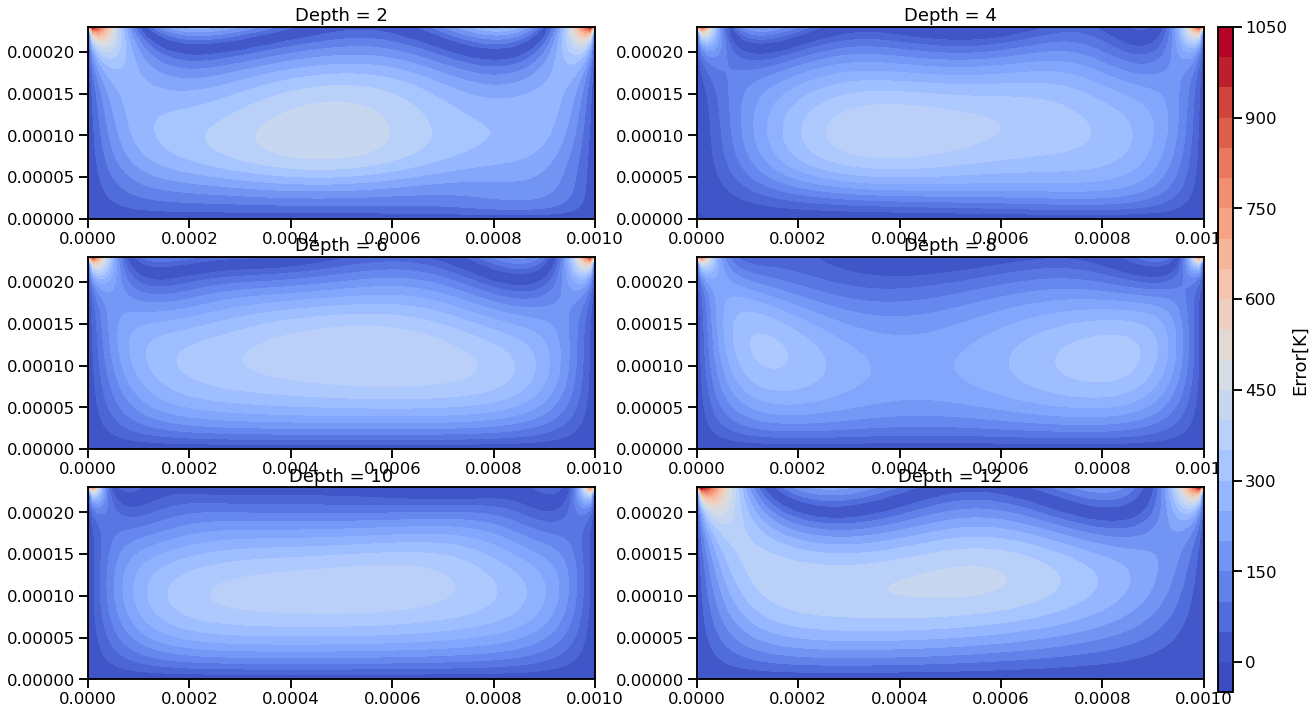

In [2]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 12))

losses = []

for depth, ax in zip([2, 4, 6, 8, 10, 12], (ax1, ax2, ax3, ax4, ax5, ax6)):
   
    dde.config.set_random_seed(12345)
    
    data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 0,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1000,
                       anchors=input_data)
    
    net = dde.nn.FNN([3] + [20] * depth + [1], "sin", "Glorot normal")
    net.apply_feature_transform(feature_transform)
    net.apply_output_transform(modify_output)

    model = dde.Model(data, net)
    model.compile("adam", lr=1e-3)

    losshistory, train_state = model.train(iterations=0, display_every=1000)
    weights = 1/np.array(losshistory.loss_train[0])
    
    dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=1000, maxfun = 1000, maxls=50)
    model.compile('L-BFGS', loss_weights=weights*np.array([1, 10]))
    
    losshistory, train_state = model.train(display_every=10)
    
    Y = model.predict(X)
    predict = griddata((np.ravel(x), np.ravel(y)), np.abs(Y[:,0]-T), (xi[None,:], yi[:,None]), method='cubic')
    im = ax.contourf(xi, yi, predict, 25, cmap=plt.cm.coolwarm, vmin=0, vmax=1000)
    
    ax.set_title('Depth = {}'.format(depth))
    if ax == ax1:
        cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('Error[K]')
    
    losses.append(losshistory)

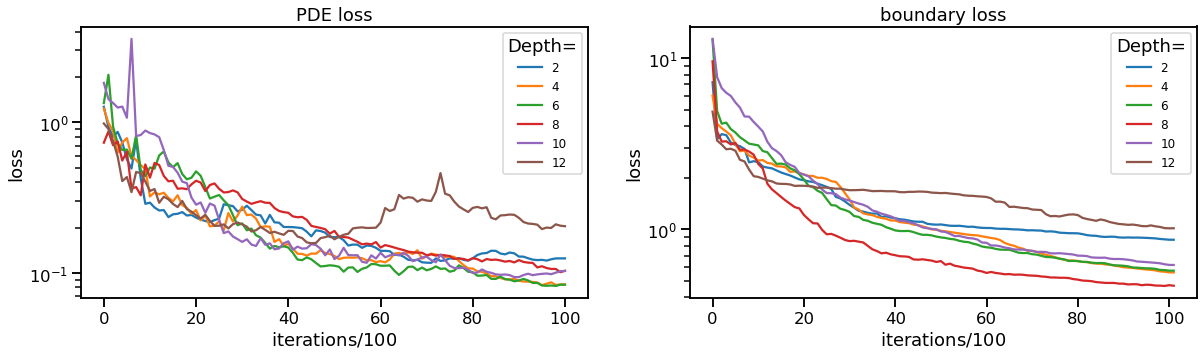

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20, 5))

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlabel(r'iterations/$100$')
ax2.set_xlabel(r'iterations/$100$')
ax1.set_ylabel('loss')
ax2.set_ylabel('loss')

for loss, depth in zip(losses ,[2, 4, 6, 8, 10, 12]):
    
    ax1.plot(np.array(loss.loss_train).T[0, 2:], label = depth)
    ax2.plot(np.array(loss.loss_train).T[1, 1:], label = depth)
    
#ax1.legend(title = 'Depth=', ncol=6, bbox_to_anchor= (1.6, 1.4))
ax1.legend(title = 'Depth=', fontsize = 12)
ax2.legend(title = 'Depth=', fontsize = 12)
ax1.set_title('PDE loss')
ax2.set_title('boundary loss')
plt.savefig('parameter_pics/depth_loss.pdf', bbox_inches='tight')
plt.show()